# TP4 : Mise en pratique de la détection d'objets avec PyTorch et Hugging Face

## Introduction

Dans ce TP, nous allons mettre en pratique les concepts de détection d'objets vus dans le cours. Vous allez apprendre à :
1. Télécharger un modèle pré-entraîné de détection d'objets depuis Hugging Face
2. Préparer et transformer des images pour l'inférence
3. Exécuter le modèle pour obtenir des prédictions
4. Analyser les tenseurs de sortie du modèle
5. Implémenter l'algorithme de Non-Maximum Suppression (NMS)
6. Visualiser les résultats avant et après l'application de NMS

## Prérequis

Assurez-vous d'avoir installé les bibliothèques nécessaires :

In [ ]:
# Installation des bibliothèques nécessaires
!pip3 install torch torchvision transformers datasets pillow matplotlib

## Partie 1 : Téléchargement et préparation du modèle

Nous allons utiliser un modèle YOLO (You Only Look Once) compact depuis Hugging Face pour la détection d'objets. YOLO est un algorithme populaire pour la détection d'objets en temps réel qui prédit à la fois les boîtes englobantes et les classes des objets en une seule passe.

In [9]:
import torch
import torchvision
from transformers import AutoImageProcessor, AutoModelForObjectDetection
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import requests
from io import BytesIO
import random

# Téléchargement du modèle YOLOv5 depuis Hugging Face
model_name = "hustvl/yolos-tiny"  # Un modèle léger de détection d'objets
feature_extractor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModelForObjectDetection.from_pretrained(model_name)

# Vérification si CUDA est disponible et déplacement du modèle sur GPU si possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Modèle chargé et prêt à être utilisé sur {device}")

Modèle chargé et prêt à être utilisé sur cpu


## Partie 2 : Téléchargement et préparation des images

Téléchargeons quelques images pour tester notre modèle de détection d'objets.

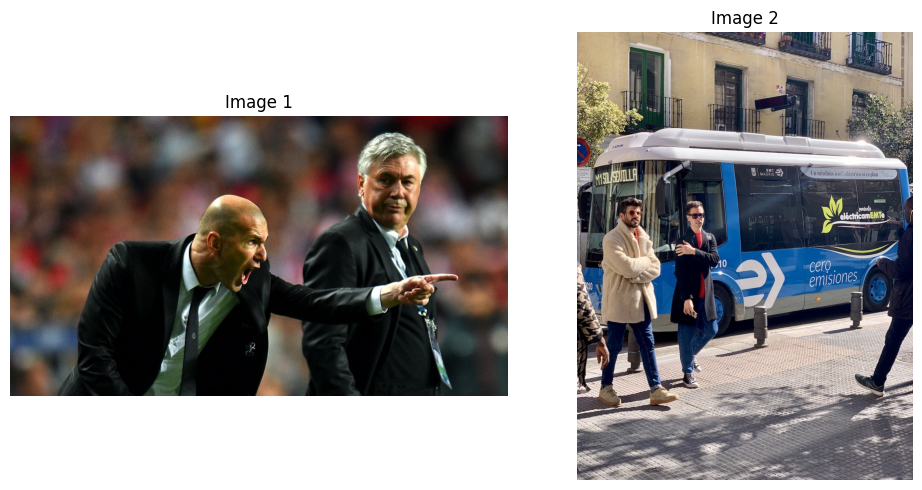

In [10]:
# URLs des images à tester
image_urls = [
    "https://raw.githubusercontent.com/ultralytics/yolov5/master/data/images/zidane.jpg",
    "https://raw.githubusercontent.com/ultralytics/yolov5/master/data/images/bus.jpg",
]

# Téléchargement et préparation des images
images = []
original_images = []

for url in image_urls:
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    original_images.append(img.copy())
    images.append(img)

# Affichage des images originales
plt.figure(figsize=(15, 5))
for i, img in enumerate(original_images):
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image {i+1}")
plt.tight_layout()
plt.show()

## Partie 3 : Inférence avec le modèle

Maintenant, nous allons passer les images à travers notre modèle et récupérer les prédictions.

In [11]:
# Fonction d'inférence
def run_inference(image, feature_extractor, model, device):
    # Préparation de l'image
    inputs = feature_extractor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Exécution du modèle
    with torch.no_grad():
        outputs = model(**inputs)
    
    return outputs

# Exécuter l'inférence sur nos images
results = []
for img in images:
    output = run_inference(img, feature_extractor, model, device)
    results.append(output)

print("Inférence terminée pour toutes les images")

Inférence terminée pour toutes les images


## Partie 4 : Analyse des tenseurs de sortie du modèle

Analysons maintenant les tenseurs de sortie pour comprendre comment notre modèle représente les objets détectés.

In [12]:
# Examinons la structure des sorties du modèle
def analyze_model_output(output):
    print("Structure de sortie du modèle :")
    for key, value in output.items():
        if isinstance(value, torch.Tensor):
            print(f"{key}: Tensor de forme {value.shape}, type {value.dtype}")
        else:
            print(f"{key}: {type(value)}")
    
    # Examinons les prédictions (logits)
    pred_logits = output.logits[0]  # Forme: [num_queries, num_classes]
    pred_boxes = output.pred_boxes[0]  # Forme: [num_queries, 4]
    
    print(f"\nNombre de boîtes prédites: {pred_boxes.shape[0]}")
    print(f"Nombre de classes: {pred_logits.shape[1]}")
    
    return pred_logits, pred_boxes

# Analysons la sortie pour la première image
pred_logits, pred_boxes = analyze_model_output(results[0])

Structure de sortie du modèle :
logits: Tensor de forme torch.Size([1, 100, 92]), type torch.float32
pred_boxes: Tensor de forme torch.Size([1, 100, 4]), type torch.float32
last_hidden_state: Tensor de forme torch.Size([1, 1893, 192]), type torch.float32

Nombre de boîtes prédites: 100
Nombre de classes: 92


In [19]:
print(model.vit)

YolosModel(
  (embeddings): YolosEmbeddings(
    (patch_embeddings): YolosPatchEmbeddings(
      (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
    (interpolation): InterpolateInitialPositionEmbeddings()
  )
  (encoder): YolosEncoder(
    (layer): ModuleList(
      (0-11): 12 x YolosLayer(
        (attention): YolosSdpaAttention(
          (attention): YolosSdpaSelfAttention(
            (query): Linear(in_features=192, out_features=192, bias=True)
            (key): Linear(in_features=192, out_features=192, bias=True)
            (value): Linear(in_features=192, out_features=192, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): YolosSelfOutput(
            (dense): Linear(in_features=192, out_features=192, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): YolosIntermediate(
          (dense): Linear(in_featur

### À vous de jouer ! Analysez les tenseurs de sortie

À partir de l'analyse précédente, répondez aux questions suivantes :

1. Quelle est la forme des tenseurs `pred_logits` et `pred_boxes` ?
2. Que représente chaque dimension de ces tenseurs ?
3. Comment sont encodées les coordonnées des boîtes ?

Complétez le code ci-dessous pour extraire les détections pertinentes :

In [ ]:
# À COMPLÉTER : Extrayez les scores et les boîtes englobantes
def extract_predictions(results, image, threshold=0.5):
    # Récupération des classes et des noms
    id2label = model.config.id2label
    
    # On récupère les prédictions
    outputs = results
    
    # Conversion en probabilités avec softmax
    probas = outputs.logits.softmax(-1)[0, :, :-1]  # Dernier indice est pour "no object"
    
    # À COMPLÉTER : Récupérez le score maximum et l'indice de classe pour chaque boîte
    scores = # ...
    labels = # ...
    
    # Filtrage des prédictions par score
    # À COMPLÉTER : Filtrez les scores en fonction du seuil
    keep = # ...
    
    # Récupération des boîtes au format (x1, y1, x2, y2)
    boxes = outputs.pred_boxes[0, keep].cpu()
    
    # Conversion des boîtes au format normalisé de l'image
    # À COMPLÉTER : Convertissez les coordonnées
    h, w = image.size[::-1]
    scaled_boxes = # ...
    
    return scaled_boxes, scores[keep], labels[keep], [id2label[i.item()] for i in labels[keep]]

# Test de notre fonction d'extraction
# À COMPLÉTER : Utilisez la fonction extract_predictions pour obtenir les détections

## Partie 5 : Implémentation de Non-Maximum Suppression (NMS)

Les modèles de détection d'objets produisent souvent plusieurs détections pour un même objet. L'algorithme de NMS permet de filtrer ces détections redondantes en ne conservant que les plus pertinentes.

In [ ]:
# À COMPLÉTER : Implémentez l'algorithme de NMS
def non_maximum_suppression(boxes, scores, threshold=0.5):
    """
    Implémentation de l'algorithme Non-Maximum Suppression
    
    Args:
        boxes: Tenseur des boîtes englobantes au format (x1, y1, x2, y2)
        scores: Tenseur des scores de confiance pour chaque boîte
        threshold: Seuil d'IoU pour supprimer les boîtes redondantes
    
    Returns:
        indices: Indices des boîtes à conserver
    """
    # S'il n'y a pas de boîtes, retourner une liste vide
    if len(boxes) == 0:
        return []
    
    # Conversion en numpy si nécessaire
    if isinstance(boxes, torch.Tensor):
        boxes = boxes.cpu().numpy()
    if isinstance(scores, torch.Tensor):
        scores = scores.cpu().numpy()
    
    # À COMPLÉTER : Triez les boîtes par score (ordre décroissant)
    # ...
    
    # Calculez l'aire de chaque boîte
    # À COMPLÉTER: Calculez les aires des boîtes
    # ...
    
    # Liste pour stocker les indices des boîtes à conserver
    keep = []
    
    # Tant qu'il reste des boîtes à traiter
    # À COMPLÉTER: Implémentez l'algorithme NMS
    # ...
    
    return keep

## Partie 6 : Visualisation des détections avant et après NMS

Visualisons maintenant les détections avant et après application de l'algorithme NMS.

In [ ]:
# Fonction pour visualiser les boîtes
def visualize_predictions(image, boxes, scores, classes, title="Détections"):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()
    
    # Affichage de chaque boîte
    for box, score, cls in zip(boxes, scores, classes):
        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1
        
        # Création d'un rectangle
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
        # Affichage du texte
        plt.text(x1, y1, f'{cls}: {score:.2f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Préparation des résultats avant NMS
def process_and_visualize(image_idx, threshold=0.3, nms_threshold=0.5):
    image = original_images[image_idx]
    result = results[image_idx]
    
    # Extraction des prédictions
    # À COMPLÉTER : Utilisez votre fonction extract_predictions ici
    # ...
    
    # Visualisation avant NMS
    visualize_predictions(image, boxes, scores, class_names, title="Détections avant NMS")
    
    # Application de NMS
    # À COMPLÉTER : Utilisez votre fonction non_maximum_suppression ici
    # ...
    
    # Visualisation après NMS
    # À COMPLÉTER : Visualisez les résultats après NMS
    # ...

# Test sur les trois images
for i in range(len(images)):
    process_and_visualize(i)

## Conclusion

Dans ce TP, vous avez appris à :
1. Utiliser un modèle de détection d'objets pré-entraîné via Hugging Face
2. Analyser les tenseurs de sortie d'un modèle de détection
3. Implémenter l'algorithme de Non-Maximum Suppression (NMS) pour filtrer les détections redondantes
4. Visualiser les résultats de détection

Ces compétences sont essentielles pour travailler avec des modèles de vision par ordinateur dans des applications réelles.

## Exercices supplémentaires

1. Essayez de modifier le seuil de confiance pour les détections. Comment cela affecte-t-il les résultats ?
2. Testez différents seuils pour l'algorithme NMS. Quel impact cela a-t-il sur les détections finales ?
3. Essayez d'implémenter d'autres métriques pour évaluer la qualité des détections, comme la précision moyenne (mAP).
4. Testez le modèle sur vos propres images. Quelles sont ses forces et ses faiblesses ? 